In [13]:
import torch
import torchvision.transforms as T
from diffusers import AutoencoderDC
from PIL import Image
from io import BytesIO
from utils import PIL_to_latent, latent_to_PIL, make_grid

import requests

In [2]:
model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)

In [5]:
URL="https://github.com/geronimi73/3090_shorts/blob/main/assets/3.jpg?raw=True"

image = Image.open(BytesIO(requests.get(URL).content))
transform = T.Compose([ T.Resize(1024, antialias=True), T.CenterCrop(1024) ])
image = transform(image)
image.size

(1024, 1024)

In [19]:
[i*32 for i in range(1, 8)]

[32, 64, 96, 128, 160, 192, 224]

32


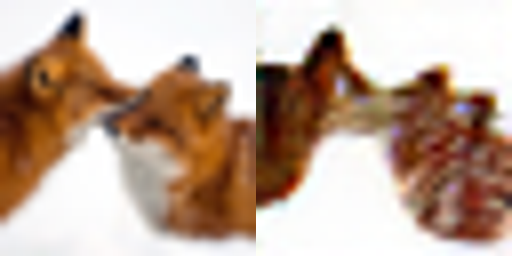

64


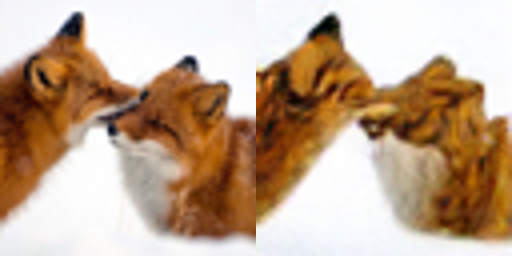

96


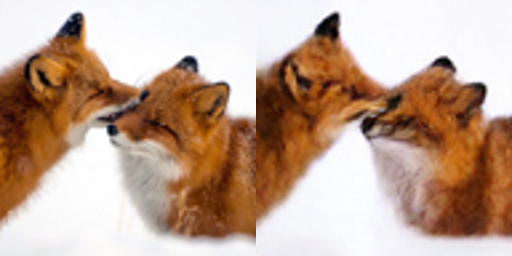

128


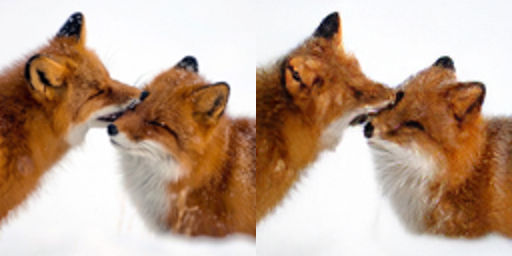

160


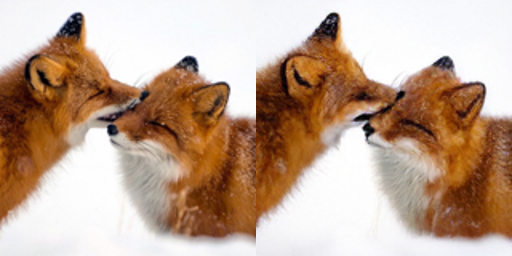

192


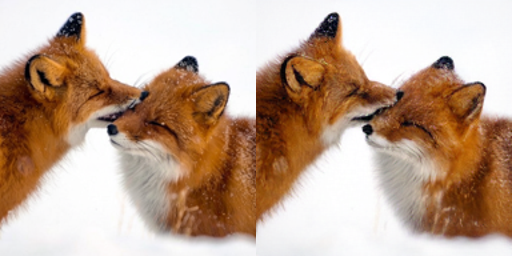

224


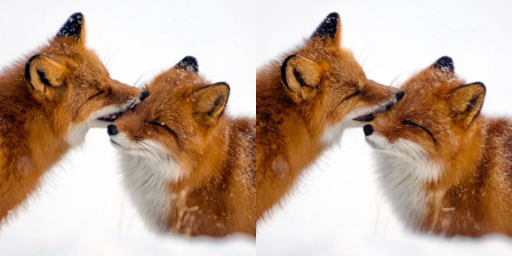

In [20]:
display_size = 256
size = 32

for size in [i*32 for i in range(1, 8)]:
    img_orig = image.resize((size, size))
    img_roundtrip = latent_to_PIL(PIL_to_latent(img_orig, dcae), dcae)
    img_orig, img_roundtrip = img_orig.resize((display_size, display_size)), img_roundtrip.resize((display_size, display_size))
    print(size)
    display(make_grid([img_orig, img_roundtrip], 1,2))

OK, I remembered this wrong. The scaling factor is not applied for decoding and encoding but before and after passing it to the model!!

Check this out:
https://github.com/huggingface/diffusers/blob/5b1dcd15848f6748c6cec978ef962db391c4e4cd/examples/dreambooth/train_dreambooth_lora_sana.py#L1345C1-L1364C65
```python
for step, batch in enumerate(train_dataloader):
    models_to_accumulate = [transformer]
    with accelerator.accumulate(models_to_accumulate):
        prompts = batch["prompts"]

        # encode batch prompts when custom prompts are provided for each image -
        if train_dataset.custom_instance_prompts:
            prompt_embeds, prompt_attention_mask = compute_text_embeddings(prompts, text_encoding_pipeline)

        # Convert images to latent space
        if args.cache_latents:
            model_input = latents_cache[step]
        else:
            vae = vae.to(accelerator.device)
            pixel_values = batch["pixel_values"].to(dtype=vae.dtype)
            model_input = vae.encode(pixel_values).latent
            if args.offload:
                vae = vae.to("cpu")
        model_input = model_input * vae_config_scaling_factor
        model_input = model_input.to(dtype=weight_dtype)
```

---> `model_input = model_input * vae_config_scaling_factor` !!!

Latents are **multiplied** with the scaling factor! And then ..

.. when decoding denoise images:
https://github.com/huggingface/diffusers/blob/5b1dcd15848f6748c6cec978ef962db391c4e4cd/src/diffusers/pipelines/sana/pipeline_sana.py#L953

```python
if output_type == "latent":
    image = latents
else:
    latents = latents.to(self.vae.dtype)
    try:
        image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
    except torch.cuda.OutOfMemoryError as e:
        warnings.warn(
            f"{e}. \n"
            f"Try to use VAE tiling for large images. For example: \n"
            f"pipe.vae.enable_tiling(tile_sample_min_width=512, tile_sample_min_height=512)"
        )
    if use_resolution_binning:
        image = self.image_processor.resize_and_crop_tensor(image, orig_width, orig_height)
```

This might be why this entire thing has not been working so far!